In [43]:
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import plotly.express as px
spark = SparkSession.builder.getOrCreate()
#.\.venv\Scripts\activate in terminal for virtual environment

In [2]:
masterdata = spark.read.parquet("cleaned_data/Masterdata.parquet")
masterdata.createOrReplaceTempView("masterdata")

inbound_95 = spark.read.parquet("cleaned_data/Inbound_95%.parquet")
inbound_95.createOrReplaceTempView("inbound_95")

inbound_avg = spark.read.parquet("cleaned_data/Inbound_Avg.parquet")
inbound_avg.createOrReplaceTempView("inbound_avg")

inventory = spark.read.parquet("cleaned_data/Inventory.parquet")
inventory.createOrReplaceTempView("inventory")

picking_95 = spark.read.parquet("cleaned_data/Picking_95%.parquet")
picking_95.createOrReplaceTempView("picking_95")

picking_avg = spark.read.parquet("cleaned_data/Picking_Avg.parquet")
picking_avg.createOrReplaceTempView("picking_avg")

In [3]:
inbound_95_extended = inbound_95.join(masterdata, on="SKU", how="left")
inbound_95_extended.createOrReplaceTempView("inbound_95_extended")

inbound_avg_extended = inbound_avg.join(masterdata, on="SKU", how="left")
inbound_avg_extended.createOrReplaceTempView("inbound_avg_extended")

inventory_extended = inventory.join(masterdata, on="SKU", how="left")
inventory_extended.createOrReplaceTempView("inventory_extended")

picking_95_extended = picking_95.join(masterdata, on="SKU", how="left")
picking_95_extended.createOrReplaceTempView("picking_95_extended")

picking_avg_extended = picking_avg.join(masterdata, on="SKU", how="left")
picking_avg_extended.createOrReplaceTempView("picking_avg_extended")

In [ ]:
#inbound_95_extended.orderBy("SKU").show(5)
#inventory_extended.orderBy("SKU").show(5)
#picking_95_extended.orderBy("SKU").show(5)

+--------------+-------------------+------------------+-----------+-----------+----------+-----------+
|           SKU|               Date|Quantity_inventory|Weight [kg]|Length [cm]|Width [cm]|Height [cm]|
+--------------+-------------------+------------------+-----------+-----------+----------+-----------+
|20000036909601|2023-03-31 00:00:00|              15.0|       0.11|      38.08|     27.24|       1.24|
|20000375115161|2023-03-31 00:00:00|             162.0|       0.22|      28.54|      18.0|        3.1|
|20000747090157|2023-03-31 00:00:00|               2.0|       0.19|      20.51|     18.79|       3.57|
|20000963045184|2023-03-31 00:00:00|             275.0|        0.2|      29.67|      23.6|       2.76|
|20002472323174|2023-03-31 00:00:00|              50.0|       0.27|      27.51|      16.7|       3.67|
+--------------+-------------------+------------------+-----------+-----------+----------+-----------+
only showing top 5 rows


#### Distinct SKUs in masterdata

In [5]:
spark.sql("""
          SELECT COUNT(DISTINCT SKU) AS DISTINCT_SKUs FROM masterdata
          """).show()

+-------------+
|DISTINCT_SKUs|
+-------------+
|        86174|
+-------------+



#### Distinct models in masterdata 

In [6]:
spark.sql("""
    SELECT COUNT(*) AS DISTINCT_MODELS
    FROM(
        SELECT SUBSTRING(SKU, 1, 6) as sku_prefix,
            COUNT(DISTINCT SKU) as unique_skus
        FROM masterdata 
        GROUP BY SUBSTRING(SKU, 1, 6)
        ORDER BY sku_prefix
    )
""").show()

+---------------+
|DISTINCT_MODELS|
+---------------+
|          70060|
+---------------+



In [ ]:
spark.sql("""
    SELECT COUNT(*) AS DISTINCT_MODELS_masterdata
    FROM(
        SELECT SUBSTRING(SKU, 1, 6) as sku_prefix,
            COUNT(DISTINCT SKU) as unique_skus
        FROM masterdata 
        GROUP BY SUBSTRING(SKU, 1, 6)
        ORDER BY sku_prefix
    )
""").show()

+---------------+
|DISTINCT_MODELS|
+---------------+
|          70060|
+---------------+



In [15]:
spark.sql("""
    SELECT COUNT(*) AS DISTINCT_MODELS_inventory
    FROM(
        SELECT SUBSTRING(SKU, 1, 6) as sku_prefix,
            COUNT(DISTINCT SKU) as unique_skus
        FROM inventory_extended 
        GROUP BY SUBSTRING(SKU, 1, 6)
        ORDER BY sku_prefix
    )
""").show()

+-------------------------+
|DISTINCT_MODELS_inventory|
+-------------------------+
|                    32867|
+-------------------------+



#### Largest and heaviest SKUs


In [7]:
spark.sql("""
    SELECT * 
    FROM masterdata
    WHERE `Weight [kg]` > 25 OR`Length [cm]` > 210 OR `Width [cm]` > 125 OR `Height [cm]` > 40
    """).show()

+--------------+-----------+-----------+----------+-----------+
|           SKU|Weight [kg]|Length [cm]|Width [cm]|Height [cm]|
+--------------+-----------+-----------+----------+-----------+
|23020809950195|      19.13|     211.16|     96.69|      26.51|
|27973785565384|      17.88|     167.01|    125.08|      29.07|
|20106786005159|       25.6|      120.0|      40.0|       22.0|
|31422898614144|       5.31|       82.4|      44.1|       40.7|
|29012088798937|       48.0|      192.0|     110.0|       20.0|
|23095771954363|       52.0|      192.0|     102.0|       19.0|
|31480447484537|       32.0|      118.0|      82.0|       25.0|
+--------------+-----------+-----------+----------+-----------+



#### Distinct SKUs received inbound 95% 

In [8]:
inbound_SKUs = spark.sql("""
               SELECT SKU, SUM(Quantity_Received) AS Quantity, `Weight [kg]`, `Length [cm]`, `Width [cm]`, `Height [cm]`  
               FROM inbound_95_extended
               GROUP BY SKU, `Weight [kg]`, `Length [cm]`, `Width [cm]`, `Height [cm]`
               ORDER BY Quantity DESC
            """)

inbound_SKUs.show()

inbound_SKUs.select("SKU").count()

+--------------+--------+-----------+-----------+----------+-----------+
|           SKU|Quantity|Weight [kg]|Length [cm]|Width [cm]|Height [cm]|
+--------------+--------+-----------+-----------+----------+-----------+
|31114244722367|  5004.0|       0.43|      32.74|      16.8|       6.75|
|29065735822373|  3501.0|       0.08|      21.06|      9.62|       2.75|
|20049552466284|  3500.0|       0.49|      51.56|     26.79|       4.93|
|33678965591584|  3017.0|       0.08|      20.88|      9.42|       2.75|
|26271074360050|  3000.0|       0.49|      45.34|     33.34|        4.5|
|36491028368052|  3000.0|       0.04|        7.5|       7.5|        2.6|
|36389124819011|  2990.0|       0.05|        3.7|       3.1|        1.3|
|23605808499016|  2799.0|       0.14|       27.4|      15.5|        3.8|
|23037613724073|  2799.0|       0.12|       24.7|      18.9|        1.9|
|30845798826374|  2500.0|        0.5|      48.01|     30.32|       4.59|
|20393205388592|  2397.0|       0.19|      20.03|  

3832

#### Distinct SKUs in inventory 

In [ ]:
inventory_SKUs = spark.sql("""
               SELECT SKU, SUM(Quantity_inventory) AS Quantity, `Weight [kg]`, `Length [cm]`, `Width [cm]`, `Height [cm]`  
               FROM inventory_extended
               GROUP BY SKU, `Weight [kg]`, `Length [cm]`, `Width [cm]`, `Height [cm]`
               ORDER BY Quantity DESC
            """)

#inventory_SKUs.show()

print(inventory_SKUs.select("SKU").count())


inventory_SKUs = spark.sql("""
               SELECT SKU, SUM(Quantity_inventory) AS Quantity  
               FROM inventory_extended
               GROUP BY SKU
               ORDER BY Quantity DESC
            """)

#inventory_SKUs.show()

print(inventory_SKUs.select("SKU").count())

inventory_SKUs = spark.sql("""
               SELECT SKU, Quantity_inventory AS Quantity  
               FROM inventory_extended
               ORDER BY Quantity DESC
            """)

#inventory_SKUs.show()

print(inventory_SKUs.select("SKU").count())

print("Varför är dessa olika tal??")

35889
35889
38716
Varför är dessa olika tal??


#### Distinct SKUs sent picking 95% 

In [10]:
picking_SKUs = spark.sql("""
               SELECT SKU, SUM(PIECES_PICKED) AS Quantity, `Weight [kg]`, `Length [cm]`, `Width [cm]`, `Height [cm]`  
               FROM picking_95_extended
               GROUP BY SKU, `Weight [kg]`, `Length [cm]`, `Width [cm]`, `Height [cm]`
               ORDER BY Quantity DESC
            """)

picking_SKUs.show()

picking_SKUs.select("SKU").count()

+--------------+--------+-----------+-----------+----------+-----------+
|           SKU|Quantity|Weight [kg]|Length [cm]|Width [cm]|Height [cm]|
+--------------+--------+-----------+-----------+----------+-----------+
|20585934507425|  1129.0|       0.12|      20.12|     17.72|        8.0|
|28464713557281|   853.0|       0.12|      20.12|     17.72|        8.0|
|30804556669192|   422.0|       0.56|      27.81|     22.64|      17.88|
|34186504387046|   348.0|       0.08|      14.73|     12.11|       2.39|
|20807636044519|   341.0|       0.83|       34.0|     23.59|      12.73|
|27396650721318|   287.0|       0.84|      34.33|      23.8|      12.75|
|33033974220741|   262.0|       0.13|      20.42|      9.48|       5.03|
|35407605042691|   257.0|       0.27|       38.1|      28.2|       3.78|
|35405085410878|   252.0|       0.27|      35.22|      25.5|       3.79|
|25868380454532|   232.0|       0.08|      13.81|     11.86|        2.4|
|32817312799882|   224.0|        0.1|      23.23|  

10750

#### Distinct SKUs with movement during one week and total active SKUs 

In [11]:
inbound_outbound_SKUs = picking_SKUs.union(inbound_SKUs)
print("Distinct SKUs in inbound and outbound 95%:", end=" ")
print(inbound_outbound_SKUs.select("SKU").distinct().count())

all_SKUs = inbound_outbound_SKUs.union(inventory_SKUs)
print("Distinct SKUs in inbound, outbound 95% and inventory:", end=" ")
print(all_SKUs.select("SKU").distinct().count())

Distinct SKUs in inbound and outbound 95%: 14196
Distinct SKUs in inbound, outbound 95% and inventory: 44489


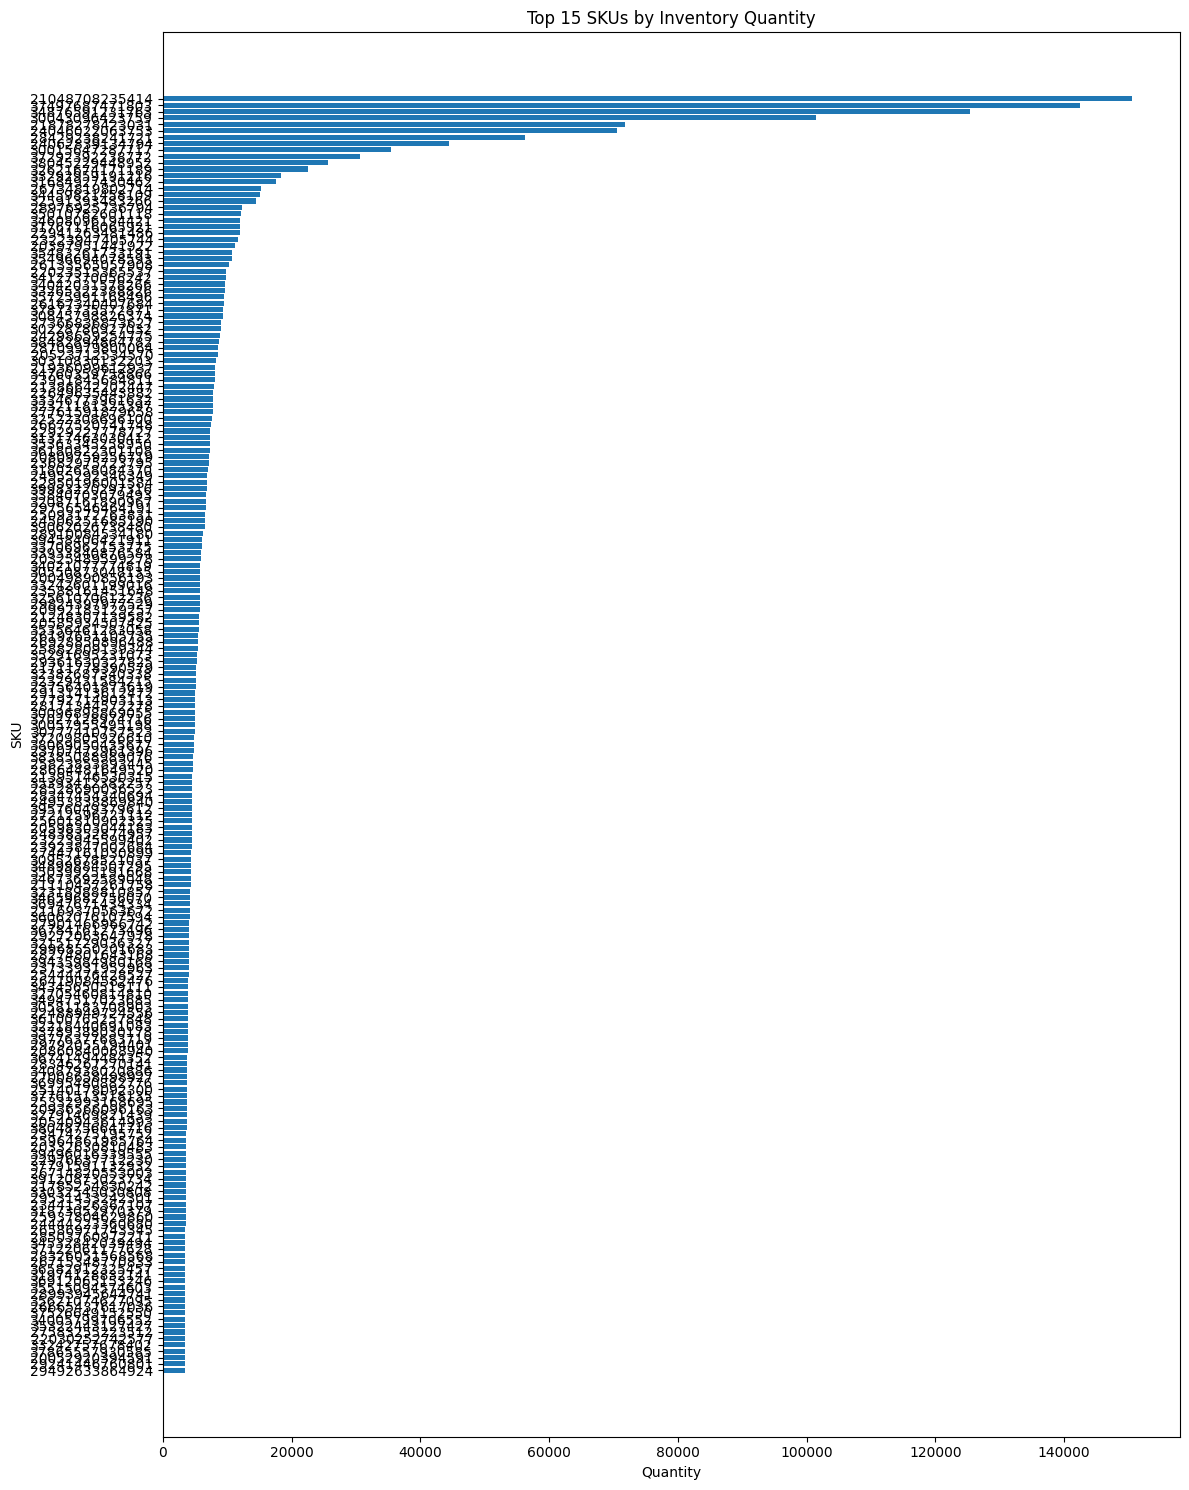

In [ ]:
#inventory_SKUs.show()

inventory_pd = inventory_SKUs.limit(200).toPandas() #top 200 SKUs

plt.figure(figsize=(12, 15))
plt.barh(inventory_pd['SKU'], inventory_pd['Quantity'])
plt.xlabel('Quantity')
plt.ylabel('SKU')
plt.title('Top 15 SKUs by Inventory Quantity')
plt.gca().invert_yaxis()  # Highest values at top
plt.tight_layout()
plt.show()